In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc
from quantize import * 
%load_ext autoreload
%autoreload 2

In [2]:
codebook = np.array([(2, 0), (-2, 0), (1, 1), (1, -1), (-1, 1), (-1, -1), (0, 2), (0, -2)])
normalized = codebook/np.linalg.norm(codebook, axis=1, keepdims=True)
codebook, normalized

(array([[ 2,  0],
        [-2,  0],
        [ 1,  1],
        [ 1, -1],
        [-1,  1],
        [-1, -1],
        [ 0,  2],
        [ 0, -2]]),
 array([[ 1.        ,  0.        ],
        [-1.        ,  0.        ],
        [ 0.70710678,  0.70710678],
        [ 0.70710678, -0.70710678],
        [-0.70710678,  0.70710678],
        [-0.70710678, -0.70710678],
        [ 0.        ,  1.        ],
        [ 0.        , -1.        ]]))

In [3]:
def point_on_pyramid(x:np.array, k):
    x_l1 = np.sum(np.abs(x))
    x_hat = k*x/x_l1
    return x_hat, np.round(x_hat)

NameError: name 'pvq_search' is not defined

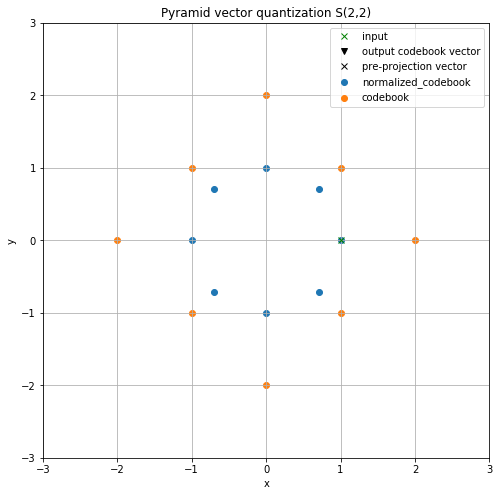

In [4]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Pyramid vector quantization S(2,2)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(( -3, 3))
ax.set_ylim((-3, 3))

line_input, = ax.plot([], [], 'gx', lw=20, label='input')
line_output, = ax.plot([], [], 'kv', lw=20, label='output codebook vector')
line_preproj, = ax.plot([], [], 'kx', lw=20, label='pre-projection vector')
ax.scatter(normalized[:,0], normalized[:,1], label='normalized_codebook')
ax.scatter(codebook[:,0], codebook[:,1], label='codebook')
ax.legend()
ax.grid()

# initialization function: plot the background of each frame
def init():
    line_input.set_data([], [])
    return (line_input,)

# animation function. This is called sequentially
def animate(t):
    pt = np.exp(2*np.pi* 0.01 * 1j * t)
    x = pt.real
    y = pt.imag
    line_input.set_data(x, y)
    act, rounded = pvq_search(np.array([x,y]), 2)
    
    line_output.set_data(rounded[0], rounded[1])
    line_preproj.set_data(act[0], act[1])

    return (line_input,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)

HTML(anim.to_html5_video())

In [ ]:
a = -0.77
x = np.array([a, -np.sqrt(1-a**2)])
x /= np.linalg.norm(x)
act, rounded = point_on_pyramid2(x, 2)
print(act, rounded)
plt.figure(figsize=(8,8))
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.scatter(normalized[:,0], normalized[:,1], label='normalized_codebook')
plt.scatter(codebook[:,0], codebook[:,1], label='codebook')
plt.plot([act[0]], [act[1]], 'xk', label='unrounded_solution')
plt.plot([rounded[0]], [rounded[1]], 'v', label='rounded_solution', linewidth=8)
plt.plot([x[0]], [x[1]], 's')
plt.grid()
plt.legend()

In [5]:
# Determine how to allocate bits between the gain and the shape of the vector
def fine_alloc(a, N, k_fine):
    """Given a total number of bits, calculate the number of bits for the gain-shape quantization"""
    a_shape = a/N + 0.5*np.log2(N) - k_fine
    a_shape = np.round(a_shape)
    a_gain = a - a_shape
    return a_gain, a_shape

for i in range(2, 20):
    a_g, a_f = fine_alloc(10, i, 0)
    print(f"For N={i}, bits for gain= {a_g}, bits for shape={a_f}")


For N=2, bits for gain= 4.0, bits for shape=6.0
For N=3, bits for gain= 6.0, bits for shape=4.0
For N=4, bits for gain= 6.0, bits for shape=4.0
For N=5, bits for gain= 7.0, bits for shape=3.0
For N=6, bits for gain= 7.0, bits for shape=3.0
For N=7, bits for gain= 7.0, bits for shape=3.0
For N=8, bits for gain= 7.0, bits for shape=3.0
For N=9, bits for gain= 7.0, bits for shape=3.0
For N=10, bits for gain= 7.0, bits for shape=3.0
For N=11, bits for gain= 7.0, bits for shape=3.0
For N=12, bits for gain= 7.0, bits for shape=3.0
For N=13, bits for gain= 7.0, bits for shape=3.0
For N=14, bits for gain= 7.0, bits for shape=3.0
For N=15, bits for gain= 7.0, bits for shape=3.0
For N=16, bits for gain= 7.0, bits for shape=3.0
For N=17, bits for gain= 7.0, bits for shape=3.0
For N=18, bits for gain= 7.0, bits for shape=3.0
For N=19, bits for gain= 7.0, bits for shape=3.0


In [6]:
# Number of points in the codebook
def num_points_in_pvq(L, K):
    if L >= 0 and K == 0:
        return 1
    if K >= 1 and L == 0:
        return 0
    return num_points_in_pvq(L-1, K) + num_points_in_pvq(L-1, K-1) + num_points_in_pvq(L, K-1)
    
# Encode a pyramid vq codebook vector into an integer index
def encode_pvq_vector(x, K):
    b = 0
    k = K
    L = len(x)
    l = L
 
    for x_i in x:
        if abs(x_i) == 0:
            b += 0
        if abs(x_i) == 1:
            b += num_points_in_pvq(l-1, k) + (0.5 * (1-np.sign(x_i))) * num_points_in_pvq(l-1, k-1)
        if abs(x_i) > 1:
            b += num_points_in_pvq(l-1, k) + 2*np.sum([num_points_in_pvq(l-1, k-j) for j in range(1, abs(x_i))]) + 0.5 * (1-np.sign(x_i)) * num_points_in_pvq(l-1, k-abs(x_i))
        k  -= abs(x_i)
        l -= 1
        if k == 0:
            break
    return int(b)

# Decode a pyramid vq codebook vector index into the codebook vector
def decode_pvq_vector(b, L, K):
    x = np.zeros((L, ), dtype=np.int)
    xb = 0
    k = K
    l = L
    i = 0
    while i < L:
        step_2, step_3, step_4, step_5 = True, True, True, True
        if b == xb:
            # step 1
            x[i] = 0
            step_2, step_3, step_4 = False, False, False
        # step 2            
        if step_2:
            if b < xb + num_points_in_pvq(l-1, k):            
                x[i] = 0
                step_3 = False
            else:
                xb += num_points_in_pvq(l-1, k)
                j = 1
        # step 3
        if step_3:
            while b >= xb + 2 *num_points_in_pvq(l-1,k-j):
                xb += 2 * num_points_in_pvq(l-1,k-j)
                if j < k:
                    j += 1
                else: 
                    break
            if b < xb + 2 *num_points_in_pvq(l-1,k-j):
                if xb <= b < xb+num_points_in_pvq(l-1,k-j):
                    x[i] = j
                else:
                    x[i] = -j
        # step 4
        if step_4:
            k -= abs(x[i])
            l -= 1
            i += 1
            if k > 0:
                step_5 = False
        # step 5
        if step_5:
            if k > 0:
                x[L-1] = k - abs(x[i])
            break
    return x
    
            

In [7]:
c = [-1,1]
b = encode_pvq_vector(np.array(c), 2)
print(c)
decoded = decode_pvq_vector(b, len(c), 2)
print(f'in: {c} idx: {b} decoded: {decoded}')

[-1, 1]
in: [-1, 1] idx: 4 decoded: [-1  1]


In [8]:
for c in codebook:
    b = encode_pvq_vector(np.array(c), 2)
    decoded = decode_pvq_vector(b, len(c), 2)
    print(f'in: {c} idx: {b} decoded: {decoded} success: {np.allclose(c, decoded)}')

in: [2 0] idx: 6 decoded: [2 0] success: True
in: [-2  0] idx: 7 decoded: [-2  0] success: True
in: [1 1] idx: 2 decoded: [1 1] success: True
in: [ 1 -1] idx: 3 decoded: [ 1 -1] success: True
in: [-1  1] idx: 4 decoded: [-1  1] success: True
in: [-1 -1] idx: 5 decoded: [-1 -1] success: True
in: [0 2] idx: 0 decoded: [0 2] success: True
in: [ 0 -2] idx: 1 decoded: [ 0 -2] success: True


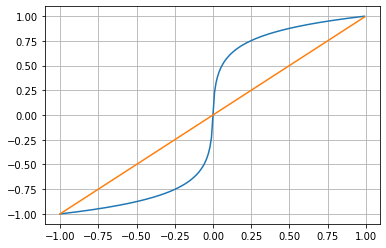

In [9]:
def mu_law_fn(x, mu=255):
    return np.sign(x) * np.log(1+mu*np.abs(x))/np.log(1+mu)

def inv_mu_law_fn(y, mu=255):
    return np.sign(y)/mu * ((1+mu)**np.abs(y) - 1)

x = np.arange(-1, 1, 0.01)
y = mu_law_fn(x)
x_hat = inv_mu_law_fn(y)
plt.plot(x, y)
plt.plot(x, x_hat)
plt.grid()

In [10]:
# Full PVQ algorithm

def encode_decode(x, R):
    k_fine = 0
    # Allocate bits for gain and shape
    R_gain, R_shape = fine_alloc(R, len(x), k_fine):
    
    # Separate gain and shape
    gain = np.linalg.norm(x)
    shape = x / gain
    
    # Mu-law scalar quantize gain
    # TODO
    
    # Find k that satisfies R_shape
    # TODO k = 
    
    # PVQ the shape
    codebook_vector = point_on_pyramid(x, k)
    # Find index of codebook vector
    b = encode_pvq_vector(codebook_vector, k)
    
    # Transmit index
    
    # DECODER
    codebook_vector_decoded = decode_pvq_vector(b, len(x), k)
    
    # normalize to reconstruct shape
    decoded_shape = codebook_vector_decoded/np.linalg.norm(codebook_vector_decoded)
    
    # reconstruct gain
    s
        
    


SyntaxError: invalid syntax (<ipython-input-10-e8340a631d2f>, line 6)

In [33]:
from gain_shape_quantize import *
from quantize import vQuantizeUniform, vDequantizeUniform

In [13]:
for c in codebook:
    b = encode_pvq_vector(np.array(c), 2, N)
    decoded = decode_pvq_vector(b, len(c), 2, N)
    print(f'in: {c} idx: {b} decoded: {decoded} success: {np.allclose(c, decoded)}')

in: [2 0] idx: 6 decoded: [2 0] success: True
in: [-2  0] idx: 7 decoded: [-2  0] success: True
in: [1 1] idx: 2 decoded: [1 1] success: True
in: [ 1 -1] idx: 3 decoded: [ 1 -1] success: True
in: [-1  1] idx: 4 decoded: [-1  1] success: True
in: [-1 -1] idx: 5 decoded: [-1 -1] success: True
in: [0 2] idx: 0 decoded: [0 2] success: True
in: [ 0 -2] idx: 1 decoded: [ 0 -2] success: True


In [31]:
L = 10
x = np.random.rand(L) * 2 - 1
b = 41
k_fine=-2
gain, shape = quantize_gain_shape(x, len(x), b, k_fine=k_fine)
print(gain, shape)
dequantized = dequantize_gain_shape(gain, shape, b, len(x), k_fine=k_fine)

vq_error = 10*np.log10(np.mean((x-dequantized)**2))
# calculate scalar quantization error
scalar_quant = vDequantizeUniform(vQuantizeUniform(x, int(b//len(x))), int(b//len(x)))
sq_error = 10*np.log10(np.mean((x-scalar_quant)**2))

# Calcualte FP quantization error
x = np.random.rand(10) * 2 - 1
scale_bits = 3
mantissa_bits = int((b - scale_bits)/L)
scale = ScaleFactor(np.max(x), scale_bits, mantissa_bits)
mantissa = vMantissa(x, scale, scale_bits, mantissa_bits)
fp_quant = vDequantize(scale, mantissa, scale_bits, mantissa_bits)
fp_error = 10*np.log10(np.mean((x-fp_quant)**2))

print(f"input: {x}\nvq_decoded:{dequantized} scalar_decoded: {scalar_quant} fp_decoded: {fp_quant}\nvq_err:{vq_error}dB scalar_err: {sq_error}dB fp_err:{fp_error}dB")

bits_gain: 7 bits_shape 34
original gain: 2.096183593794986
k 26 used bits 33.96013838797717
Encoded codebook vector: [ 4 -3  2 -1  4  3  0 -4 -1 -4]
Quantized shape index: 12651263935
46 12651263935
7 34
decoded gain:2.1385522808407327
k 26
Decoded codebook vector: [ 4 -3  2 -1  4  3  0 -4 -1 -4]
input: [ 0.50109109 -0.79484578 -0.50507654 -0.87120909  0.2676444   0.03753963
  0.36513157  0.92884837 -0.78289436 -0.5285729 ]
vq_decoded:[ 0.91188176 -0.68391132  0.45594088 -0.22797044  0.91188176  0.68391132
  0.         -0.91188176 -0.22797044 -0.91188176] scalar_decoded: [ 0.93333333 -0.66666667  0.4        -0.26666667  0.8         0.66666667
  0.         -0.93333333 -0.26666667 -0.93333333] fp_decoded: [ 0.62561095 -0.87585533 -0.62561095 -0.87585533  0.37536657  0.
  0.37536657  0.87585533 -0.87585533 -0.62561095]
vq_err:-26.32956462920552dB scalar_err: -28.07217127920019dB fp_err:-21.511811395114947dB


In [182]:
L = 6
bit_alloc = 32
k_fine = 0
x = np.random.rand(L) * 2 - 1
x = x /np.linalg.norm(x)
mid_idx, side_idx, theta_idx = split_band_encode(x, bit_alloc, k_fine=k_fine)
print(mid_idx, side_idx, theta_idx)
x_hat = split_band_decode(mid_idx, side_idx, theta_idx, bit_alloc, L, k_fine)
error = 10*np.log10(np.mean((x-x_hat)**2))
print(list(zip(x, x_hat)))

expected_snr = 
print(error)

theta  0.3918438067972992
bitalloc theta, mid, side 11 12 9
encode theta: 0.3918438067972992
2424 142 255
decoded theta: 0.391356192801855
bitalloc theta, mid, side 11 12 9
[(-0.3523701305775535, -0.33945018830640206), (-0.015443906399272445, -0.00889484831692469), (0.5913741206641795, 0.6156843329961951), (-0.513196039271239, -0.5002804341426784), (-0.4278187024320822, -0.4109704629076156), (0.2819120596324311, 0.29402384132364223)]
-36.32590407366538


In [136]:
x = np.random.rand(L) * 2 - 1
x = x /np.linalg.norm(x)
idx, b = quantize_pvq(x, 16)
x_hat = dequantize_pvq(idx, L, 16)
x, x_hat

(array([-0.67190593,  0.52659609, -0.32741075, -0.40501997]),
 array([-0.66666667,  0.53333333, -0.33333333, -0.4       ]))

In [139]:
x = np.random.rand(L) * 2 - 1
x = x /np.linalg.norm(x)

mid = len(x) // 2
left = x[:mid]
right = x[mid:]

# Calculate M and S
M = (left + right) / 2
S = (left - right) / 2
M_l2 = np.linalg.norm(M)
S_l2 = np.linalg.norm(S)
m = M / M_l2
s = S / S_l2
theta = np.arctan(S_l2/ M_l2)  # Captures distribution of energy

left2 = m * np.cos(theta) + s * np.sin(theta)
right2 = m * np.cos(theta) - s * np.sin(theta)
left2 /= np.sqrt(2)
right2 /= np.sqrt(2)

theta

1.2820369562145864

In [140]:
left, left2

(array([-0.84062648, -0.14275668]), array([-0.84062648, -0.14275668]))

In [687]:
L = 4
K = 5
N = pvq_codebook_size(L,K)
codebook = []
oops = False
for b in range(N[L][K]):
#     cb = decode_pvq_vector(b, L, K, N)
    cb = decoder(b, L, K, N).step_1()   
    if np.sum(abs(cb)) != K:
        print(b, "l1 norm is not K")
    # Test to see if it's already in there
    for i,cb2 in enumerate(codebook):
        if np.allclose(cb2, cb):
            print("Found duplicate vector", i, b, cb2, cb)
            oops = True
    codebook.append(cb)
    if oops:
        break

print(np.array(codebook))

[[ 0  0  0  5]
 [ 0  0  0 -5]
 [ 0  0  1  4]
 ...
 [-4 -1  0  0]
 [ 5  0  0  0]
 [-5  0  0  0]]


In [628]:
N

array([[1, 0, 0],
       [1, 2, 2],
       [1, 4, 8]])

In [677]:
# decode_pvq_vector(37, L, K, N)
decoder(20, L, K, N).step_1() 

12
14
1 2 2
18
2 2 2
k 2


array([-1,  0,  2])

In [678]:
decoder(22, L, K, N).step_1()

12
14
1 2 2
18
2 2 2
22
k 1


array([-1,  1,  1])

In [542]:
N

array([[  1,   0,   0,   0,   0,   0],
       [  1,   2,   2,   2,   2,   2],
       [  1,   4,   8,  12,  16,  20],
       [  1,   6,  18,  38,  66, 102]])

In [266]:
# x = np.array([0.53963551,  0.94695102,  0.19858073, -0.54743883])
x = np.array([-0.68288664, -0.68028159, -0.09013877, -0.16080877])
x /= np.linalg.norm(x)
print(x)
y, pre_search = pvq_search(x, 5)
y, pre_search #, np.round(y), y - np.round(y)

[-0.69584506 -0.69319058 -0.09184924 -0.16386027]
[2. 2. 0. 0.]
Remaining pulses: 1.0


(array([2.11535831, 2.10728872, 0.27922028, 0.4981327 ]),
 array([-2, -2,  0, -1]))

In [730]:
nlines = AssignMDCTLinesFromFreqLimits(1024, 48000)
print(nlines)
# sf_bands = ScaleFactorBands(1024)

[  4.   5.   4.   4.   5.   5.   6.   6.   7.   8.   9.  10.  12.  14.
  16.  19.  24.  30.  38.  47.  56.  76. 107. 149. 363.]


In [ ]:
[12,15,9]

In [167]:
def get_pulses(i):
    return  i if i<8 else (8 + (i&7)) << ((i>>3)-1)
get_pulses(10)

10

In [172]:
pvq_compute_k_for_R(14, 10)

(7, 72)